# Conditional Diffusion Probabilistic Model (CDPM) for 3D Images generation

This tutorial illustrates how to use MONAI for training a 2D CDPM[1] for 3D images generation.

[1] - [Peng et al. "Generating Realistic 3D Brain MRIs Using a Conditional Diffusion Probabilistic Model"](https://arxiv.org/abs/2212.08034)

In [1]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
import os
import tempfile
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import DataLoader
from monai.transforms import AddChanneld, CenterSpatialCropd, Compose, Lambdad, LoadImaged, Resized, ScaleIntensityd
from monai.utils import set_determinism
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm

from generative.inferers import DiffusionInferer

# TODO: Add right import reference after deployed
from generative.networks.nets.cdpm import UNet_2Plus1_Model
from generative.networks.schedulers import DDPMScheduler

print_config()

MONAI version: 1.1.0
Numpy version: 1.21.6
Pytorch version: 1.12.1+cu113
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: a2ec3752f54bfc3b40e7952234fbeb5452ed63e3
MONAI __file__: /home/Nobias/.local/lib/python3.7/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 4.0.2
scikit-image version: 0.19.3
Pillow version: 9.3.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.13.1+cu113
tqdm version: 4.64.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.3
pandas version: 1.3.5
einops version: 0.6.0
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#instal

In [2]:
print(torch.cuda.is_available())

True


## Setup data directory

You can specify a directory with the MONAI_DATA_DIRECTORY environment variable.

This allows you to save results and reuse downloads.

If not specified a temporary directory will be used.

In [3]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
directory = '/home/Nobias/data/MONAI_DATA_DIRECTORY'
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/home/Nobias/data/MONAI_DATA_DIRECTORY


## Set deterministic training for reproducibility

In [4]:
set_determinism(0)

## Setup Decathlon Dataset and training and validation dataloaders

In [5]:
train_transform = Compose(
    [
        LoadImaged(keys=["image"]),
        Lambdad(keys="image", func=lambda x: x[:, :, :, 1]),
        AddChanneld(keys=["image"]),
        ScaleIntensityd(keys=["image"]),
        CenterSpatialCropd(keys=["image"], roi_size=[176, 224, 155]),
        Resized(keys=["image"], spatial_size=(32, 48, 32)),
    ]
)

val_transform = Compose(
    [
        LoadImaged(keys=["image"]),
        Lambdad(keys="image", func=lambda x: x[:, :, :, 1]),
        AddChanneld(keys=["image"]),
        ScaleIntensityd(keys=["image"]),
        CenterSpatialCropd(keys=["image"], roi_size=[176, 224, 155]),
        Resized(keys=["image"], spatial_size=(32, 48, 32)),
    ]
)

/home/Nobias/.local/lib/python3.7/site-packages/monai/utils/deprecate_utils.py:107: FutureWarning: <class 'monai.transforms.utility.array.AddChannel'>: Class `AddChannel` has been deprecated since version 0.8. please use MetaTensor data type and monai.transforms.EnsureChannelFirst instead.
  warn_deprecated(obj, msg, warning_category)


In [6]:
train_ds = DecathlonDataset(
    root_dir=root_dir, task="Task01_BrainTumour", transform=train_transform, section="training", download=False
)

train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=1)

val_ds = DecathlonDataset(
    root_dir=root_dir, task="Task01_BrainTumour", transform=val_transform, section="validation", download=False
)

val_loader = DataLoader(val_ds, batch_size=20, shuffle=False, num_workers=1)

Loading dataset: 100%|████████████████████████████████████████████████████████████████████████████████| 96/96 [01:14<00:00,  1.28it/s]


### Visualization of the training images


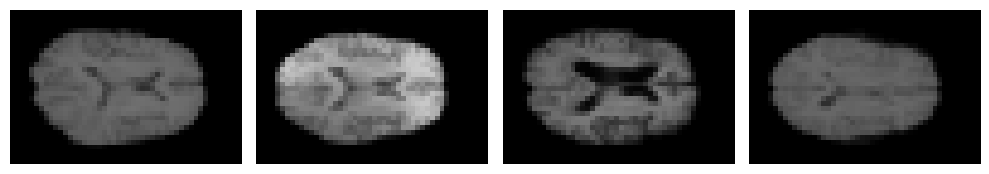

In [7]:
plt.subplots(1, 4, figsize=(10, 6))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.imshow(train_ds[i * 20]["image"][0, :, :, 15].detach().cpu(), vmin=0, vmax=1, cmap="gray")
    plt.axis("off")
plt.tight_layout()
plt.show()

### Define network, scheduler, optimizer, and inferer

In [8]:
device = torch.device("cuda")

model = UNet_2Plus1_Model(
    in_channels=1,
    out_channels=1,
    model_channels=128,
    attention_resolutions=[16, 8],
    num_res_blocks=2,
    channel_mult=[1, 1, 2, 4],
    num_heads=1,
)
model.to(device)

scheduler = DDPMScheduler(num_train_timesteps=1000)

inferer = DiffusionInferer(scheduler)

optimizer = torch.optim.Adam(params=model.parameters(), lr=2.5e-5)

### Model training
##### Take longer to converge as we have much more traning combinations.

Epoch 0: 100%|██████████| 194/194 [01:52<00:00,  1.72it/s, loss=0.486]


Conditioning on [0] slices, predicting [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15].


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:03<00:00, 15.72it/s]


shape torch.Size([1, 15, 1, 32, 48]), torch.Size([15, 1, 32, 48])
Conditioning on [8, 9, 10, 11, 12, 13, 14, 15] slices, predicting [16, 17, 18, 19, 20, 21, 22, 23].


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:03<00:00, 15.70it/s]


shape torch.Size([1, 8, 1, 32, 48]), torch.Size([8, 1, 32, 48])
Conditioning on [16, 17, 18, 19, 20, 21, 22, 23] slices, predicting [24, 25, 26, 27, 28, 29, 30, 31].


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:03<00:00, 15.78it/s]


shape torch.Size([1, 8, 1, 32, 48]), torch.Size([8, 1, 32, 48])


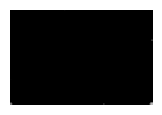

Epoch 50: 100%|██████████| 194/194 [01:51<00:00,  1.73it/s, loss=0.29]


Conditioning on [0] slices, predicting [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15].


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:03<00:00, 15.66it/s]


shape torch.Size([1, 15, 1, 32, 48]), torch.Size([15, 1, 32, 48])
Conditioning on [8, 9, 10, 11, 12, 13, 14, 15] slices, predicting [16, 17, 18, 19, 20, 21, 22, 23].


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:04<00:00, 15.60it/s]


shape torch.Size([1, 8, 1, 32, 48]), torch.Size([8, 1, 32, 48])
Conditioning on [16, 17, 18, 19, 20, 21, 22, 23] slices, predicting [24, 25, 26, 27, 28, 29, 30, 31].


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:03<00:00, 15.65it/s]


shape torch.Size([1, 8, 1, 32, 48]), torch.Size([8, 1, 32, 48])


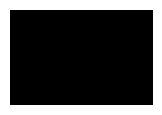

Epoch 100: 100%|████████| 194/194 [01:51<00:00,  1.74it/s, loss=0.256]


Conditioning on [0] slices, predicting [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15].


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:03<00:00, 15.67it/s]


shape torch.Size([1, 15, 1, 32, 48]), torch.Size([15, 1, 32, 48])
Conditioning on [8, 9, 10, 11, 12, 13, 14, 15] slices, predicting [16, 17, 18, 19, 20, 21, 22, 23].


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:04<00:00, 15.55it/s]


shape torch.Size([1, 8, 1, 32, 48]), torch.Size([8, 1, 32, 48])
Conditioning on [16, 17, 18, 19, 20, 21, 22, 23] slices, predicting [24, 25, 26, 27, 28, 29, 30, 31].


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:04<00:00, 15.58it/s]


shape torch.Size([1, 8, 1, 32, 48]), torch.Size([8, 1, 32, 48])


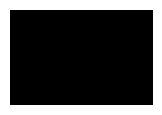

Epoch 101:  16%|█▍       | 32/194 [00:18<01:36,  1.69it/s, loss=0.303]


KeyboardInterrupt: 

In [9]:
n_epochs = 200
val_interval = 50
epoch_loss_list = []
val_epoch_loss_list = []

scaler = GradScaler()
total_start = time.time()
for epoch in range(n_epochs):
    model.train()
    epoch_loss = 0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=70)
    progress_bar.set_description(f"Epoch {epoch}")
    # At most sample 16 slices for each batch
    max_frames=16
    for step, batch in progress_bar:
        images = batch["image"].to(device)#[1, 1, 32, 48, 32]
        images[...,0]=0. # Trick used to indicate where to start

        ### Create images and context
        # randomly sample next batch to fill the unused tensor
        batch_1 = next(iter(train_loader))["image"].to(device)
        context = model.get_image_context(images.permute(0,4,1,2,3), batch_1.permute(0,4,1,2,3), max_frames)
        # Create timesteps
        timesteps = torch.randint(
            0, inferer.scheduler.num_train_timesteps, (images.shape[0],), device=images.device
        ).long()
        optimizer.zero_grad(set_to_none=True)

        with autocast(enabled=True):
            # Generate random noise
            images = context[-1]
            noise = torch.randn_like(images).to(device)

            # Get model prediction
            # images = context[-1]
            noise_pred = inferer(inputs=images, diffusion_model=model, noise=noise, timesteps=timesteps, condition=context)

            loss = F.mse_loss(noise_pred.float(), noise.float())

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        epoch_loss += loss.item()

        progress_bar.set_postfix({"loss": epoch_loss / (step + 1)})
    epoch_loss_list.append(epoch_loss / (step + 1))

    if (epoch ) % val_interval == 0:
        model.eval()
        val_epoch_loss = 0
        for step, batch in enumerate(val_loader):
            images = batch["image"].to(device)
            images[...,0]=0.

            batch_1 = next(iter(val_loader))["image"].to(device)
            context = model.get_image_context(images.permute(0,4,1,2,3), batch_1.permute(0,4,1,2,3), max_frames)
            # Create timesteps
            timesteps = torch.randint(
                0, inferer.scheduler.num_train_timesteps, (images.shape[0],), device=images.device
            ).long()

            images = context[-1]
            noise = torch.randn_like(images).to(device)
            with torch.no_grad():
                with autocast(enabled=True):
                    noise_pred = inferer(inputs=images, diffusion_model=model, noise=noise, timesteps=timesteps, condition=context)
                    val_loss = F.mse_loss(noise_pred.float(), noise.float())

            val_epoch_loss += val_loss.item()
            progress_bar.set_postfix({"val_loss": val_epoch_loss / (step + 1)})
        val_epoch_loss_list.append(val_epoch_loss / (step + 1))

        # Sampling image during training
        done_frames = [0]
        mri_length = 32
        max_frames = 16
        step_size = 8
        Sample = torch.zeros((1, 32, 1, 32, 48)).to(device)
        while len(done_frames)<mri_length:
            obs_frame_indices, latent_frame_indices, obs_mask, latent_mask = model.next_indices(done_frames, mri_length, max_frames, step_size)
            frame_indices = torch.cat([torch.tensor(obs_frame_indices), torch.tensor(latent_frame_indices)]).long()

            sampled = Sample[:,frame_indices]
            print(f'Conditioning on {sorted(obs_frame_indices)} slices, predicting {sorted(latent_frame_indices)}.')

            sampled = sampled.to(device)
            context = (frame_indices.view(1,-1).to(device), obs_mask.to(device), latent_mask.to(device), sampled)

            scheduler.set_timesteps(num_inference_steps=1000)
            done_frames = done_frames + latent_frame_indices
            with autocast(enabled=True):
                image = inferer.sample(input_noise=sampled, diffusion_model=model, scheduler=scheduler, conditioning=context)
                img = image[:,len(obs_frame_indices):]
                print(f'shape {img.shape}, {Sample[0,latent_frame_indices].shape}')
                Sample[:,latent_frame_indices] = img

        plt.figure(figsize=(2, 2))
        plt.imshow(image[0,15, 0, :, :].cpu(), vmin=0, vmax=1, cmap="gray")
        plt.tight_layout()
        plt.axis("off")
        plt.show()

total_time = time.time() - total_start
print(f"train completed, total time: {total_time}.")

### Learning curves

In [10]:
print(epoch_loss_list)

[0.4864773461499165, 0.43385952618933216, 0.4103274059664343, 0.3932774242052098, 0.37972595058765607, 0.40020594492401046, 0.386953869277669, 0.3827735303142636, 0.38551762147048085, 0.37072832790232196, 0.3770226608846605, 0.36265878502241117, 0.3841928651498765, 0.38507465634149374, 0.36301448426603045, 0.3498402255558476, 0.36819205878628897, 0.3807560240792245, 0.35579510125302777, 0.343514986182611, 0.35242646080009715, 0.3437297113009335, 0.3313482161035243, 0.35312939558139783, 0.3459331321808481, 0.34172067921800714, 0.35333362720983547, 0.3295436045250942, 0.33692933357868, 0.327917997216441, 0.36267932957595156, 0.3415677099651897, 0.3427664413280094, 0.33656330952017577, 0.3330835050989672, 0.315041632996392, 0.3320941034051561, 0.2913210643167348, 0.32091206719273146, 0.31312115413626446, 0.2996846889865767, 0.2937865101338662, 0.31686120518704053, 0.3048381164823611, 0.3321807740889874, 0.3065842592071012, 0.2933129470065697, 0.3066430886842541, 0.28812271901934416, 0.299

In [11]:
print(val_epoch_loss_list)

[0.40903578996658324, 0.2832865506410599, 0.23934329748153688]


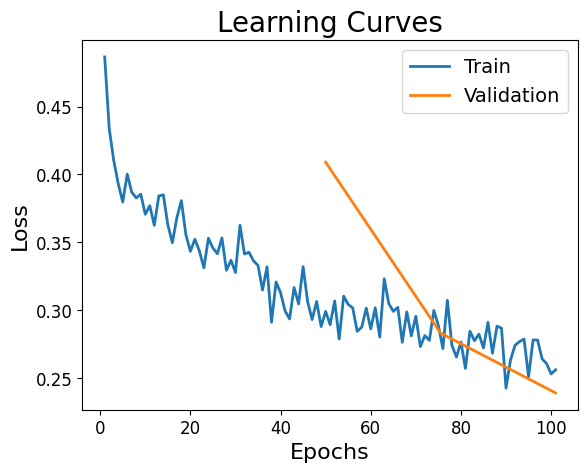

In [15]:
# plt.style.use("seaborn-v0_8")
n_epochs = 101
plt.title("Learning Curves", fontsize=20)
plt.plot(np.linspace(1, n_epochs, n_epochs), epoch_loss_list, color="C0", linewidth=2.0, label="Train")
plt.plot(
    np.linspace(val_interval, n_epochs, int(n_epochs / val_interval)+1),
    val_epoch_loss_list,
    color="C1",
    linewidth=2.0,
    label="Validation",
)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("Loss", fontsize=16)
plt.legend(prop={"size": 14})
plt.show()

### Plotting synthetic sample

In [17]:
# Sampling image during training
done_frames = [0]
mri_length = 32
max_frames = 16
step_size = 8
Sample = torch.zeros((1, 32, 1, 32, 48)).to(device)
while len(done_frames)<mri_length:
    obs_frame_indices, latent_frame_indices, obs_mask, latent_mask = model.next_indices(done_frames, mri_length, max_frames, step_size)
    frame_indices = torch.cat([torch.tensor(obs_frame_indices), torch.tensor(latent_frame_indices)]).long()

    sampled = Sample[:,frame_indices]
    print(f'Conditioning on {sorted(obs_frame_indices)} slices, predicting {sorted(latent_frame_indices)}.')

    sampled = sampled.to(device)
    context = (frame_indices.view(1,-1).to(device), obs_mask.to(device), latent_mask.to(device), sampled)

    scheduler.set_timesteps(num_inference_steps=1000)
    done_frames = done_frames + latent_frame_indices
    with autocast(enabled=True):
        image = inferer.sample(input_noise=sampled, diffusion_model=model, scheduler=scheduler, conditioning=context)
        img = image[:,len(obs_frame_indices):]
        print(f'shape {img.shape}, {Sample[0,latent_frame_indices].shape}')
        Sample[:,latent_frame_indices] = img

Conditioning on [0] slices, predicting [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15].


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:04<00:00, 15.60it/s]


shape torch.Size([1, 15, 1, 32, 48]), torch.Size([15, 1, 32, 48])
Conditioning on [8, 9, 10, 11, 12, 13, 14, 15] slices, predicting [16, 17, 18, 19, 20, 21, 22, 23].


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:04<00:00, 15.58it/s]


shape torch.Size([1, 8, 1, 32, 48]), torch.Size([8, 1, 32, 48])
Conditioning on [16, 17, 18, 19, 20, 21, 22, 23] slices, predicting [24, 25, 26, 27, 28, 29, 30, 31].


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:03<00:00, 15.74it/s]

shape torch.Size([1, 8, 1, 32, 48]), torch.Size([8, 1, 32, 48])


In [24]:
Sample = Sample.permute(0,3,4,1,2)

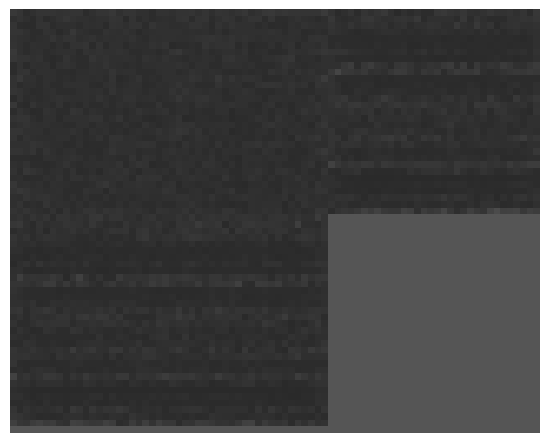

In [27]:

plt.style.use("default")
plotting_image_0 = np.concatenate([Sample[0, 0, :, :, 15].cpu(), np.flipud(Sample[0, 0, :, 24, :].cpu().T)], axis=1)
plotting_image_1 = np.concatenate([np.flipud(Sample[0, 0, 15, :, :].cpu().T), np.zeros((32, 32))], axis=1)
plt.imshow(np.concatenate([plotting_image_0, plotting_image_1], axis=0), vmin=-2.0, vmax=4, cmap="gray")
plt.tight_layout()
plt.axis("off")
plt.show()